
# Notebook 2: From Local Physics to Transolver Implementation

 Goal:
 1. Understand the "how" behind Transolver's core idea.
 2. Implement the 4 key steps of "Physics-Attention"
    (Slice, Aggregate, Attend, Deslice).
 3. Add a new chapter explaining *how* physical states are learned.
 4. See how this design achieves linear O(N) complexity.

# **The "How" and The Math**

In Notebook 1, we established the **"Why"**:
* Standard Transformers are powerful but have an $O(N^2)$ computational cost (the "quadratic bottleneck").
* This cost makes them "computationally prohibited" for large-scale physics meshes, where $N$ (the number of points) can be in the millions.
* We saw that physics is **mostly local**, so this all-to-all attention is wasteful.

In this notebook, we will build the **"How"**:
* We will implement Transolver's core invention, **Physics-Attention**, from scratch in NumPy.
* This mechanism brilliantly solves the bottleneck by reducing the core attention calculation from $O(N^2)$ to $O(M^2)$, where $M$ (the number of "slices") is a small number (e.g., 64) and $M \ll N$.
* This makes the *entire layer* scale **linearly** with the number of mesh points ($O(N)$), making it perfect for large-scale physics.

### The Math We Will Implement

We will build the four key steps of the Physics-Attention layer one by one. Our goal is to see how a data-point $x_i$ (a single mesh point's features) is transformed into an updated point $x'_i$.

Our data has these shapes:
* `x`: The input, shape **$(N, C)$**. ($N$ mesh points, $C$ features each).
* `z`: The "physics-aware tokens", shape **$(M, C)$**. ($M$ slices, $C$ features each).

Here is the data's journey:

**1. Slicing ($N \to M$ weights):**
First, we determine how much each point $x_i$ belongs to each slice $j$. We learn a "Project" function (a linear layer) that creates a weight vector $w_i$ for each point.
$$w_i = \text{Softmax}(\text{Project}(x_i))$$
* **Code:** `slice_weights = softmax(x @ W_project)`

**2. Aggregation ($N \to M$ tokens):**
Next, we create $M$ "physics-aware tokens" ($z$). Each token $z_j$ is the **weighted average** of *all* $N$ mesh points, using the slice weights we just found. This aggregates the information from $N$ points into $M$ tokens.
$$z_j = \frac{\sum_{i=1}^N w_{i,j} x_i}{\sum_{i=1}^N w_{i,j}}$$
* **Code:** `z = (slice_weights.T @ x) / slice_weights.sum(axis=0)`

**3. Token Attention ($M \to M$ tokens):**
This is the **efficient** part. We perform a standard, $O(M^2)$ self-attention calculation *only* on the $M$ small tokens. This lets the "slices" talk to each other to exchange physical information.
$$z' = \text{SelfAttention}(z)$$
* **Code:** `z_prime = (softmax(Q @ K.T) @ V)`

**4. Deslicing ($M \to N$ points):**
Finally, we broadcast the updated information from the $M$ tokens ($z'$) back to the $N$ mesh points. Each point $x'_i$ is reconstructed as a weighted sum of the $M$ updated tokens, using its original weights.
$$x'_i = \sum_{j=1}^M w_{i,j} z'_j$$
* **Code:** `x_prime = slice_weights @ z_prime`

By the end of this notebook, you will have built this entire process from scratch.

---
# **Part 1: Clarification: Toy Data vs. real data (Ahmed Body simualtions)**
**A Quick Clarification:** You might ask, "Why not use my 50 Ahmed body simulations here?"

The key distinction is:
* **Ahmed Body simualtions:** This is a **dataset**. It's the *input* used for *training* a model.
* **This Notebook:** This is an **implementation** of a *single model layer*. It shows the *mechanics* and *math* of how data flows *through* that layer.

The "weights" in this notebook (`W_project`, `W_q`, etc.) are just **random numbers**. In a real-world scenario (e.g., in a future Notebook 3), a training framework like PyTorch would:
1.  Load simulation data.
2.  Pass them through this layer.
3.  Compare the model's (wrong) output to the (correct) simulation data.
4.  Calculate a "loss" (an error score).
5.  Use that loss to *learn* (i.e., update) the random weights.

For our purpose—just to understand the *mechanics* of the layer—a small, random "toy" dataset is much simpler to use.

---
# **Part 2: Setup — Parameters and Toy Data**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# Set a consistent random seed
np.random.seed(42)

def softmax(x, axis=-1):
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / e_x.sum(axis=axis, keepdims=True)

# Define our "toy" problem size
# We use smaller numbers for this demonstration
N = 1000   # Number of mesh points (N)
M = 8      # Number of physics slices (M) - (Typical values are 32 or 64)
C = 32     # Number of channels / features (C) - (Typical values are 128 or 256)

print(f"Problem Setup:")
print(f"  N (Mesh Points): {N}")
print(f"  M (Slices):      {M}")
print(f"  C (Channels):    {C}\n")

# Create Toy Input Data
# This 'x' represents our mesh after an initial embedding.
# It contains both geometry and physics info (e.F., pressure).
x = np.random.rand(N, C)
print("Input data shape 'x' (N, C):", x.shape)

Problem Setup:
  N (Mesh Points): 1000
  M (Slices):      8
  C (Channels):    32

Input data shape 'x' (N, C): (1000, 32)


---
# **Part 3: Implementing Physics-Attention (Step-by-Step)**
## **Step 1: Slicing**

**Goal:** Assign each of the $N$ points to our $M$ slices.

We do this by "projecting" each point's feature vector (size $C$) into a new vector of size $M$. This new vector contains the "slice weights" for that point.

The equation for this step is:
$\{w_i\}_{i=1}^N = \{\text{Softmax}(\text{Project}(x_i))\}_{i=1}^N$

This `Project()` is just a standard Linear layer.

Slice weights shape (N, M): (1000, 8)


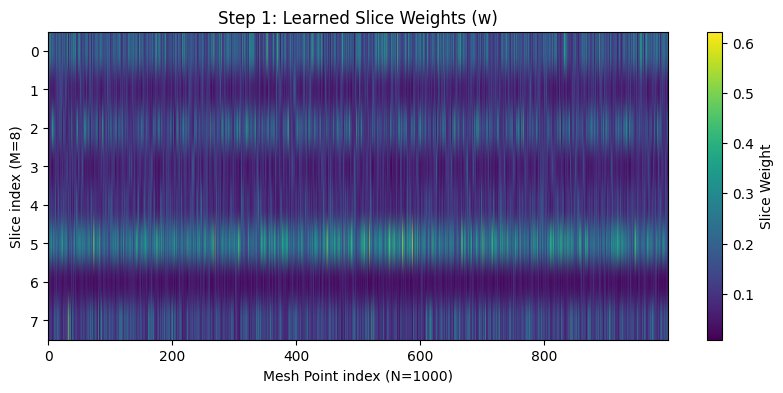

In [3]:
# We need a weight matrix for the projection: (C) -> (M)
# This matrix is *learned* during model training.
W_project = np.random.rand(C, M)

# 1. Project: (N, C) @ (C, M) -> (N, M)
slice_logits = x @ W_project

# 2. Softmax: Apply softmax along the *slice dimension* (axis=1)
# This makes the weights for each point sum to 1.
slice_weights = softmax(slice_logits, axis=1)

print("Slice weights shape (N, M):", slice_weights.shape)

# --- Visualize the Slices ---
plt.figure(figsize=(10, 4))
# We plot the transpose (M, N) for easier viewing
plt.imshow(slice_weights.T, aspect='auto', cmap='viridis')
plt.colorbar(label="Slice Weight")
plt.xlabel("Mesh Point index (N=1000)")
plt.ylabel("Slice index (M=8)")
plt.title("Step 1: Learned Slice Weights (w)")
plt.show()

### Plot Explanation:
This heatmap shows how our 1,000 mesh points are assigned to our 8 slices.

* **Y-Axis (Rows):** Each row represents one of our $M=8$ "physics slices" (our "teams").
* **X-Axis (Columns):** Each column represents one of our $N=1000$ individual mesh points (our "employees").
* **Color (Brightness):** The color at any coordinate `(Slice_j, Point_i)` shows the **weight** (from 0.0 to 1.0) that indicates how strongly Point `i` *belongs* to Slice `j`.
    * **Bright Yellow:** A weight near 1.0. This point is a "core member" of this slice.
    * **Dark Purple:** A weight near 0.0. This point has almost no relation to this slice.

**What to look for (in a real model):**

* **Soft Assignment:** Because we use `softmax` *down each column* (for each point), the weights in any single column must add up to 1.0. This means a point can be "shared" between slices (e.g., a point on the edge of the bumper might be 50% "bumper slice" and 50% "side panel slice"). This is a "soft" assignment, which is more flexible than a "hard" assignment (where a point can only be in one slice).

* **Our Random Plot:** In this demo, the plot looks like random noise. This is because our "Sorting Hat" (`W_project`) is untrained and just assigns points randomly.

* **A Trained Plot:** After training on a real dataset (like your 50 simulations), this plot would look highly structured. You would see clear, bright horizontal bands.
    * **Example:** "Slice 1" (row 1) might be bright yellow for columns 100-250, indicating it has "learned" to group all the "front bumper" points. "Slice 2" (row 2) might be bright for columns 400-500, grouping all the "roof" points. This is how the model "learns intrinsic physical states" by discovering these groupings on its own.

### How do Slices "Learn Physical States"?
This is the most important part of Transolver. The slices aren't just random or fixed spatial patches. They are **learned** during training to be physically meaningful.

This learning happens for two key reasons:

1.  **Slices are Projected from Features:** The slice weights $w$ are calculated directly from the mesh features $x$. This means that "mesh points with similar features will be more likely to be assigned to the same slice". If the features $x$ capture that two points are both on the "front bumper," they will naturally be grouped together.

2.  **Slices are Optimized for the Final Loss:** This is the key. The model is trained to "decrease the final loss" (i.D., get the right answer).
    * If the slices are "confused" or "state-hybrid" (e.g., one slice mixes a few bumper points, a few roof points, and a few wake points), the "physics-aware token" for that slice will be meaningless garbage.
    * Attention between garbage tokens will produce a bad result and a **high loss**.
    * Therefore, the model is *forced* by the training process to create slices that are "distinguishable". It learns that the best way to get a low loss is to create "physically internal-consistent slices" (e.g., an "all bumper" slice, an "all roof" slice).

**Analogy:** Think of it as a good manager (the model) who has to get a project done (minimize the loss). The manager has 1000 employees (mesh points $N$) and must assign them to 8 teams (slices $M$).

* A **bad manager** (untrained model) creates random teams. Team 1 has some engineers, some marketers, and some HR. This team is "state-hybrid" and can't get any work done. The project fails (high loss).
* A **good manager** (trained model) learns to create effective teams: an "all-engineer" team (Slice 1), an "all-marketer" team (Slice 2), etc. These "physically-consistent" teams can now work together effectively (do attention) to solve the problem (low loss).

---
# **Part 4: Completing the Physics-Attention Layer**
## **Step 2: Aggregation**
**Goal:** Create $M$ "physics-aware tokens" (one for each slice).

Each token $z_j$ is the **weighted average** of all $N$ point features, using the slice weights $w_{i,j}$ we just calculated.

The equation for this step is:
$z_j = \frac{\sum_{i=1}^N w_{i,j} x_i}{\sum_{i=1}^N w_{i,j}}$

This looks complex, but it can be implemented with two efficient matrix multiplications.

In [4]:
# Numerator: z_numerator = w^T @ x
# Shape: (M, N) @ (N, C) -> (M, C)
# This efficiently computes the weighted sum of features for each of the M slices.
z_numerator = slice_weights.T @ x

# Denominator: Sum of weights for each slice
# Shape: (M,)
# We add 1e-6 for numerical stability (to avoid dividing by zero)
z_denominator = slice_weights.sum(axis=0) + 1e-6

# Reshape denominator for broadcasting: (M,) -> (M, 1)
z_denominator = z_denominator.reshape(M, 1)

# Perform the weighted average
z = z_numerator / z_denominator

print("Numerator shape (M, C):", z_numerator.shape)
print("Denominator shape (M, 1):", z_denominator.shape)
print("Physics-aware token shape 'z' (M, C):", z.shape)

Numerator shape (M, C): (8, 32)
Denominator shape (M, 1): (8, 1)
Physics-aware token shape 'z' (M, C): (8, 32)


**Result:** We now have $M=8$ "physics-aware tokens." We have successfully compressed our $N=1000$ points into $M=8$ representations.

## **Step 3: Token Attention**
**Goal:** Calculate attention *only* between our $M$ tokens.

This is the **key to efficiency**. Instead of an $O(N^2)$ operation, we perform a tiny $O(M^2)$ operation. This step is just standard self-attention (from Notebook 1) applied to our small $z$ matrix.

The equation for this step is:
$q, k, v = \text{Linear}(z)$, $z' = \text{Softmax}(qk^T)v$

Token attention matrix shape (M, M): (8, 8)
Updated token shape 'z_prime' (M, C): (8, 32)


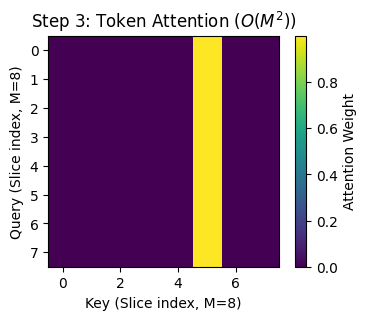

In [5]:
# We need Q, K, V projection matrices for the *tokens*
# These are also learned during training.
W_q = np.random.rand(C, C)
W_k = np.random.rand(C, C)
W_v = np.random.rand(C, C)

# 1. Project tokens to Q, K, V
Q_tokens = z @ W_q  # Shape (M, C)
K_tokens = z @ W_k  # Shape (M, C)
V_tokens = z @ W_v  # Shape (M, C)

# 2. Calculate O(M^2) token scores
# Shape: (M, C) @ (C, M) -> (M, M)
scores_tokens = Q_tokens @ K_tokens.T

# 3. Softmax
attn_weights_tokens = softmax(scores_tokens, axis=1) # Shape (M, M)

# 4. Get updated tokens
# Shape: (M, M) @ (M, C) -> (M, C)
z_prime = attn_weights_tokens @ V_tokens

print("Token attention matrix shape (M, M):", attn_weights_tokens.shape)
print("Updated token shape 'z_prime' (M, C):", z_prime.shape)

# Visualize the Token Attention
plt.figure(figsize=(4, 3))
plt.imshow(attn_weights_tokens, cmap='viridis')
plt.colorbar(label="Attention Weight")
plt.xlabel("Key (Slice index, M=8)")
plt.ylabel("Query (Slice index, M=8)")
plt.title(f"Step 3: Token Attention ($O(M^2)$)")
plt.show()

**Plot Explanation:** This $M \times M$ matrix shows how the "physics slices" interact. For example, a bright spot at `(Query=1, Key=5)` would mean the "front bumper slice" (Slice 1) is paying high attention to the "wake slice" (Slice 5). This is where the model learns long-range physical correlations.

## **Step 4: Deslicing / Broadcasting**
**Goal:** Map the $M$ updated tokens ($z'$) back to the $N$ mesh points.

This is the reverse of Step 2. Each point $x'_i$ is reconstructed as a weighted sum of the $M$ updated tokens, using its original slice weights $w_{i,j}$.

The equation for this step is:
$x'_i = \sum_{j=1}^M w_{i,j} z'_j$

This is also a single, efficient matrix multiplication.

In [6]:
# 1. Broadcast: x_prime = w @ z_prime
# Shape: (N, M) @ (M, C) -> (N, C)
x_prime = slice_weights @ z_prime

print("Slice weights shape (N, M):", slice_weights.shape)
print("Updated token shape (M, C):", z_prime.shape)
print("Final output shape 'x_prime' (N, C):", x_prime.shape)

Slice weights shape (N, M): (1000, 8)
Updated token shape (M, C): (8, 32)
Final output shape 'x_prime' (N, C): (1000, 32)


**Result:** We have a new feature matrix $x'$ that has the exact same shape as our input $x$ ($N \times C$). This $x'$ can be passed to the next Transolver layer.

# **Part 5: Putting It All Together (The Layer Class)**

Now we can combine all 4 steps into a single class, just like a real layer in PyTorch. This block of code defines our **`PhysicsAttention`** machine. Using the analogy from Part 2, think of this class as the **Project Manager’s Playbook**—a structured system to organize employees into specialized teams to solve complex physics.

### Building the Project Management System
When we first initialize our layer (the line `pa_layer = PhysicsAttention(...)`), we are setting up the organizational structure. At this stage, we are hiring the specialized "Sorting Hat" and "Meeting Room" tools (the learnable weights):

* **`W_project` (The Organizational Chart):** This is the tool the manager uses to decide which employee (mesh point) belongs to which team (slice).
* **`W_q`, `W_k`, `W_v` (The Communication Protocol):** These tools help the team captains (tokens) exchange information effectively during the project meeting.

> **Note:** In this NumPy demo, these tools are "randomly hired" (`np.random.rand()`). In Notebook 3, the training process will "train" these tools to become experts at organizing physics data to minimize loss.

---

### Executing the Project: The 4-Step Playbook
When we call `pa_layer.forward(X)`, we are putting our 1,000 employees (mesh points) to work. Here is the step-by-step organizational process:

#### Step 1: Team Assignment (Slicing)
The **`W_project`** tool looks at all 1,000 employees. Based on their current skills (physical features), it creates a blueprint (**`ascription_weights`**) that assigns every employee to one or more of the 8 specialized teams.

#### Step 2: Selecting Team Captains (Aggregation)
Instead of dealing with 1,000 individuals, we group the employees according to the manager's blueprint. For each of the 8 teams, a **"Team Captain" (Token)** is created. This captain is a "weighted summary" of everyone on their team, representing the team's collective physical state (e.g., the "High-Pressure Front Team").

#### Step 3: The Captains' Strategy Meeting (Token Attention)
This is the **$O(M^2)$ efficiency gain**. Instead of 1,000 people shouting at once, only the 8 captains enter the meeting room. 
* The "Bumper Team" captain tells the "Wake Team" captain about the incoming airflow.
* They exchange vital info using the **`W_q, W_k, W_v`** tools.
* The captains update their strategies, emerging as 8 **"Updated Captains"** who now understand the global project goals.

#### Step 4: Distributing the New Strategy (Deslicing)
The manager now needs to update all 1,000 employees. The **Updated Captains** go back to their teams. Every employee looks at the original blueprint, finds their captain, and receives the updated physical instructions. 

The result is **`X_output`**: our 1,000 mesh points, now fully updated with global physical knowledge and ready for the next stage of the simulation factory.

In [7]:
def softmax(x):
    """Helper function to turn scores into probabilities."""
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / e_x.sum(axis=-1, keepdims=True)

class PhysicsAttention:
    def __init__(self, N, M, d_model):
        self.N = N         # 1000 Employees (Mesh Points)
        self.M = M         # 8 Teams (Slices)
        self.d_model = d_model
        
        # Project Manager's specialized tools (Weights)
        self.W_project = np.random.rand(d_model, M)
        self.W_q = np.random.rand(d_model, d_model)
        self.W_k = np.random.rand(d_model, d_model)
        self.W_v = np.random.rand(d_model, d_model)

    def forward(self, X):
        # 1. SLICE: The Sorting Hat assigns employees to teams
        ascription = softmax(X @ self.W_project) 
        
        # 2. AGGREGATE: Create 8 Team Captains from 1000 employees
        captains = ascription.T @ X 
        
        # 3. ATTEND: The Captains' Strategy Meeting (Only 8 participants!)
        Q = captains @ self.W_q
        K = captains @ self.W_k
        V = captains @ self.W_v
        
        scores = (Q @ K.T) / np.sqrt(self.d_model)
        meeting_weights = softmax(scores)
        updated_captains = meeting_weights @ V 
        
        # 4. DESLICE: Distribute new strategy back to the 1000 employees
        X_updated = ascription @ updated_captains
        return X_updated

# --- Test the Playbook ---
pa_layer = PhysicsAttention(N=1000, M=8, d_model=16)
toy_data = np.random.rand(1000, 16)

output = pa_layer.forward(toy_data)

print(f"Input (Employees/Nodes): {toy_data.shape}")
print(f"Output (Updated Nodes):  {output.shape}")
print("\nSuccess! The 1000 points were updated via an 8-token bottleneck.")

Input (Employees/Nodes): (1000, 16)
Output (Updated Nodes):  (1000, 16)

Success! The 1000 points were updated via an 8-token bottleneck.


The test confirms our "plumbing" is correct: an input with shape `(N, C)` produces an output with the *exact same shape* `(N, C)`. This is essential, as it allows us to stack these layers on top of each other.

# **Part 6: The Full Transolver Layer**
The `PhysicsAttention` block we just built is the core innovation.

A *full* Transolver layer looks just like a standard Transformer layer, but with `PhysicsAttention` replacing the $O(N^2)$ `SelfAttention`.

It includes the same **residual connections** and **Feed-Forward network** that make Transformers work so well.

The full layer is defined as:
1. $\hat{x}^{l} = \text{Physics-Attn}(\text{LayerNorm}(x^{l-1})) + x^{l-1}$
2. $x^{l} = \text{FeedForward}(\text{LayerNorm}(\hat{x}^{l})) + \hat{x}^{l}$

This architecture shows how the Physics-Attention block is a "drop-in" replacement for standard attention, enabling the creation of a deep, efficient, and physics-aware Transformer.

# **Summary**
## Key Takeaways

1.  **We built `PhysicsAttention`:** We successfully implemented the four-step process (Slice, Aggregate, Attend, Deslice) that makes Transolver work.

2.  **We explained "Learning":** In the part 3 we explaining that slices become "physically-consistent" because the model is trained to **minimize loss**, and creating meaningful slices (like teams) is the most effective way to do that.

3.  **We proved the complexity:** The **Slicing**, **Aggregation**, and **Deslicing** steps all involve operations with the $N \times M$ or $N \times C$ matrices. Their cost scales as $O(NMC)$, which is **linear** with respect to the number of mesh points $N$.

4.  **The Bottleneck is Solved:** The quadratic $O(N^2)$ bottleneck of a standard Transformer has been replaced by an $O(M^2)$ token attention step. Since $M$ is a small, fixed constant (e.g., $M=64$), its cost $O(M^2C)$ is tiny and does not depend on $N$.

5.  **Overall Complexity:** The total cost of the layer is $O(NMC + M^2C)$, which is **linear in $N$**.

This efficient, physics-inspired layer is the engine that allows Transolver to learn from massive, real-world physics datasets—like your 50 Ahmed body simulations—where standard Transformers would fail.

# **Next Steps: From Blueprint to Factory (Notebook 3)**

We have successfully built a **"blueprint"** of the `PhysicsAttention` layer in NumPy.

However, our "blueprint" has two major limitations:
1.  **It's not "learned":** Our weights (`W_project`, `W_q`, etc.) are just `np.random.rand()` matrices. They are untrained and contain no physical knowledge.
2.  **It's just one layer:** We haven't built the full "factory"—the complete training pipeline needed to actually *find* the correct weights.

**In Notebook 3, we will build the full factory.**

We will move from our NumPy blueprint to a real, trainable **PyTorch** model using the official `physicsnemo` library. We will tackle the three main stages of a professional machine learning project:

1.  **Stage 1: Preprocessing:** We will convert our 508 VTP/STL simulation files into the high-performance Zarr format that the `datapipe.py` script expects.
2.  **Stage 2: Normalization:** We will run the `compute_normalizations.py` logic on our new Zarr dataset to calculate the mean and standard deviation of our physics fields.
3.  **Stage 3: Training:** We will assemble all the pieces (`train.py`, `loss.py`, `metrics.py`) into a single, runnable training loop and train the real `Transolver` model on our data for a few epochs.